In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
#importing needed libraries

import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

import tensorflow.keras
import numpy as np
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.applications import VGG19

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

import PIL
import re
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import random
import pathlib
import shutil
import os.path
from os import path

In [2]:
# Import dataset and unzip it

!pip install gdown
import gdown

#Images
!gdown -q --id 157N9nMOpnvxbWjapQ2fPXBtx_2LixPQP
!unzip -q Variables8.zip -d Variables8

#'Fish_upload.zip'
!gdown -q --id 1cLH6yHccdoieWLpdj1ppEUAVYLqb2VUf
!unzip -q Fish_upload.zip -d Fish_upload

#For alexnet pytorch
!gdown -q --id 1l4M1AheMS5vukyo4rBGinmDeUA0bwVtx
!unzip -q All_fish.zip -d All_fish

#calsses+ Tilapia
!gdown -q --id 1-B4yBqXmS1Wq5q5sdA5We_WtndNj2nKg
!unzip -q /content/classesTalipia.zip

#proposed model
!gdown -q --id 1--u6S2bQ-INYVfQsBTn67h-QvXtNRJTW

In [ ]:
import os
if (os.path.exists("/content/classesTalipia/.ipynb_checkpoints")):
  import shutil
  shutil.rmtree("/content/classesTalipia/.ipynb_checkpoints")

In [ ]:
# Functions

#append all arrays of images 
def append_all_dataset_img_to_array():
    flag=1
    x_train=[]
    train_counter=0
    class_number=-1
    
    for folder_name in ("Bodianus","Coris","Epinephelus","Halichoeres","Lethrinus","Lutjanus","Pseudanthias","Thalassoma"):
        class_number=class_number+1
        folder_path = os.path.join("FishImages\Train", folder_name)
        print(folder_path)
        for fname in os.listdir(folder_path):  ## for loop in all files in the given directory 
            fpath = os.path.join(folder_path, fname)
            label=[class_number]
            im = load_img(fpath, target_size=(227, 227))
            im = img_to_array(im)
            if (flag==1):
                x_train=np.array([im])
                flag=0
            else:
                x_train=np.append(x_train,[im],0)
                
#resize imgage acc the model
def resize(input_shape,x):
    import numpy as np
    # resize input set
    X_resized = []
    for img in x:
        X_resized.append(np.resize(img, input_shape) / 255)
    X_resized = np.array(X_resized)
    print(X_resized.shape)
    return(X_resized)

#to load images of the QUT dataset (training,validation,test) variable as numpy arrays
def load_variables():
    import pickle
    variables_files=["/content/Variables8/all_variables_files/x_train.pckl","/content/Variables8/all_variables_files/x_val.pckl","/content/Variables8/all_variables_files/x_val_20.pckl","/content/Variables8/all_variables_files/x_test.pckl","/content/Variables8/all_variables_files/Y_train.pckl","/content/Variables8/all_variables_files/Y_val.pckl","/content/Variables8/all_variables_files/Y_val_20.pckl","/content/Variables8/all_variables_files/Y_test.pckl"]
    x_train=[];x_val=[];x_val_20=[];x_test=[]
    Y_train=[];Y_val=[];Y_val_20=[];Y_test=[]
    variables=['x_train','x_val','x_val_20','x_test','Y_train','Y_val','Y_val_20','Y_test']
    for i in range(len(variables_files)):
        f = open(variables_files[i], 'rb')
        globals()[variables[i]] = pickle.load(f)
        #variables[i] = pickle.load(f) ->         globals()['var_name'] = 'var_value'
        f.close()
        
        
def resize_variables(lenn,wid,dep):
    X_train=[]; X_val=[]; X_val_20=[]; X_test=[]
    variables=['X_train', 'X_val', 'X_val_20','X_test']
    values=['x_train', 'x_val', 'x_val_20','x_test']
    for i in range(len(variables)):
        globals()[variables[i]]=resize((lenn,wid,dep),globals()[values[i]])

In [ ]:
#plot
def plot_model_acc_loss(history):
    from matplotlib import pyplot as plt
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
#evaluate the model
# We evaluate the accuracy and the loss in the test set
def evaluate_model_testset(model):
    scores = model.evaluate(X_test, Y_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    
    
def plot_random_images_form_each_class(model,target_size2D):
    import os, random
    from tensorflow.keras.preprocessing.image import load_img
    from tensorflow.keras.preprocessing.image import img_to_array
    from tensorflow.keras.applications.vgg16 import preprocess_input
    from tensorflow.keras.applications.vgg16 import VGG16
    class_number=-1
    for folder_name in ("Bodianus","Coris","Epinephelus","Halichoeres","Lethrinus","Lutjanus","Pseudanthias","Thalassoma"):
        class_number=class_number+1
        folder_path = os.path.join("/content/Fish_upload/Fish_upload/Validation", folder_name)
        #print(folder_path)
        fpath=os.path.join(folder_path, random.choice(os.listdir(folder_path)))
        #print(f_path)
        #print(fpath)
        label=[class_number]
        image = load_img(fpath, target_size=target_size2D)
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        yhat = model.predict(image)

In [ ]:
# Models


# VGG-16

def run_model_VGG16():
    input_shape=(224,224,3)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.summary()
    for layer in base_model.layers: 
        layer.trainable = False
        print('Layer ' + layer.name + ' frozen.')
        
    last = base_model.layers[-1].output
    x = Flatten()(last)
    x = Dense(1000, activation='relu', name='fc1')(x)
    x = Dropout(0.3)(x)
    x = Dense(8, activation='softmax', name='predictions')(x)
    model = Model(base_model.input, x)
    
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.summary()
    

    epochs = 20
    batch_size = 32
    history=model.fit(X_train, Y_train,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          epochs=epochs)
    plot_model_acc_loss(history)
    return(model)


In [ ]:
# VGG-19

def run_model_VGG19():
    input_shape=(224,224,3)
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.summary()

    for layer in base_model.layers: 
        if layer.name == 'block5_conv1':
            break
        layer.trainable = False
        print('Layer ' + layer.name + ' frozen.')
        
    last = base_model.layers[-1].output
    x = Flatten()(last)
    x = Dense(1000, activation='relu', name='fc1')(x)
    x = Dropout(0.3)(x)
    x = Dense(8, activation='softmax', name='predictions')(x)
    model = Model(base_model.input, x)
    
    model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.summary()
    
    epochs = 20
    batch_size = 32
    history=model.fit(X_train, Y_train,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          epochs=epochs)
    plot_model_acc_loss(history)
    return(model)

In [ ]:
# AlexNet Pytorch

import torch
from torchvision import transforms 
from torchvision import datasets
import os


# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/All_fish/All_fish/All_fish'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Train', 'Validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['Train', 'Validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Validation']}
class_names = image_datasets['Train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


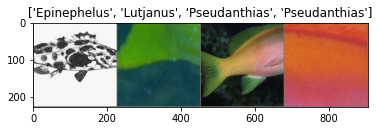

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
def run_model_AlexNet():
  model_ft = models.alexnet(pretrained=True)
  num_ftrs = model_ft.classifier[6].in_features
  model_ft.classifier[6] = nn.Linear(num_ftrs,8)
  input_size = 224
  
  model_ft = model_ft.to(device)
  
  criterion = nn.CrossEntropyLoss()
  
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

  model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)
  return model_ft

In [ ]:
# Our Model

def class_classification(images):

  for image in images:
   img_id =int(re.findall(r'\d+' , str(image))[0])
   if ("bodianus" in str(image) or 337 <= img_id <= 461 ):
    shutil.copy(image,path_1)
   elif ("coris" in str(image) or 1224 <= img_id <= 1315):
    shutil.copy(image,path_2)
   elif ("epinephelus" in str(image) or 1410 <= img_id <= 1697):
    shutil.copy(image,path_3)
   elif ("halichoeres" in str(image) or 1814 <= img_id <= 2026):
    shutil.copy(image,path_4)
   elif ("lethrinus" in str(image) or 2223 <= img_id <= 2382):
    shutil.copy(image,path_5) 
   elif ("lutjanus" in str(image) or 2437 <= img_id <= 2755):
    shutil.copy(image,path_6)
   elif ("pseudanthias" in str(image) or 3390 <= img_id <= 3576):
    shutil.copy(image,path_7)
   elif ("thalassoma" in str(image) or 4112 <= img_id <= 4241):
    shutil.copy(image,path_8)

In [ ]:
path_1="/content/Fish_Image/bodianus"
path_2="/content/Fish_Image/coris"
path_3="/content/Fish_Image/epinephelus"
path_4="/content/Fish_Image/halichoeres"
path_5="/content/Fish_Image/lethrinus"
path_6="/content/Fish_Image/lutjanus"
path_7="/content/Fish_Image/pseudanthias"
path_8="/content/Fish_Image/thalassoma"
def extract_dataset():
 if (not path.exists("/content/Fish_Image")): 
   #making sure that the data is not already extracted
  !unzip -q "/content/drive/MyDrive/FishKaggle/archive (3).zip" -d "/content/"
  os.mkdir("/content/Fish_Image/")
  #!unrar x "/content/drive/MyDrive/FishKaggle/Talipia.rar" -d "/content/Fish_Image"
  os.mkdir(path_1)
  os.mkdir(path_2)
  os.mkdir(path_3)
  os.mkdir(path_4)  
  os.mkdir(path_5)
  os.mkdir(path_6)
  os.mkdir(path_7)
  os.mkdir(path_8) 
  data_dir_raw = pathlib.Path("/content/Fish_Data/images/raw_images")
  data_dir_cropped = pathlib.Path("/content/Fish_Data/images/cropped")
  data_dir_numbered = pathlib.Path("/content/Fish_Data/images/numbered")
  images = list(data_dir_numbered.glob('*')) + list(data_dir_raw.glob('*')) + list(data_dir_cropped.glob('*')) 
  class_classification(images)

In [ ]:
def class_classification(images):

  for image in images:
   img_id =int(re.findall(r'\d+' , str(image))[0])
   if ("bodianus" in str(image) or 337 <= img_id <= 461 ):
    shutil.copy(image,path_1)
   elif ("coris" in str(image) or 1224 <= img_id <= 1315):
    shutil.copy(image,path_2)
   elif ("epinephelus" in str(image) or 1410 <= img_id <= 1697):
    shutil.copy(image,path_3)
   elif ("halichoeres" in str(image) or 1814 <= img_id <= 2026):
    shutil.copy(image,path_4)
   elif ("lethrinus" in str(image) or 2223 <= img_id <= 2382):
    shutil.copy(image,path_5) 
   elif ("lutjanus" in str(image) or 2437 <= img_id <= 2755):
    shutil.copy(image,path_6)
   elif ("pseudanthias" in str(image) or 3390 <= img_id <= 3576):
    shutil.copy(image,path_7)
   elif ("thalassoma" in str(image) or 4112 <= img_id <= 4241):
    shutil.copy(image,path_8)

In [ ]:
def import_dataset(): 
  extract_dataset()
  data_dir="/content/Fish_Image/"
  batch_size = 128
  img_height = 120
  img_width = 120
  train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,validation_split=0.1,subset="training",seed=123,image_size=(img_height, img_width),batch_size=batch_size,labels='inferred',label_mode='int')
  val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,validation_split=0.1,subset="validation",seed=123,image_size=(img_height, img_width),batch_size=batch_size,labels='inferred',label_mode='int')
  return train_ds,val_ds

In [ ]:
def create_model(): 
    img_height = 120
    img_width  = 120
    num_classes = 8 
    model = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                             layers.Conv2D(32, 5, activation='relu'),
                             layers.MaxPooling2D(),
                             layers.Conv2D(32, 3, activation='relu'),
                             layers.MaxPooling2D(),
                             #layers.Conv2D(32, 3, activation='relu'),
                             #layers.MaxPooling2D(),
                             layers.Dropout(0.2),
                             layers.Flatten(),
                             layers.Dense(128, activation='relu'),
                             layers.Dense(num_classes)])

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])
    return model

In [ ]:
def run_model() : 
    train_ds , val_ds = import_dataset()
    model = create_model()
    CNN_data = model.fit(train_ds,validation_data=val_ds,epochs=20)
    model.summary()

    acc = CNN_data.history['accuracy']
    val_acc = CNN_data.history['val_accuracy']

    loss = CNN_data.history['loss']
    val_loss = CNN_data.history['val_loss']
    epochs = 20
    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
# Transfer Learning our Model

def import_dataset_9classes(): 
  data_dir="/content/classesTalipia"
  batch_size = 128
  img_height = 120
  img_width = 120
  train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,validation_split=0.1,subset="training",seed=123,image_size=(img_height, img_width),batch_size=batch_size,labels='inferred',label_mode='int')
  val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,validation_split=0.1,subset="validation",seed=123,image_size=(img_height, img_width),batch_size=batch_size,labels='inferred',label_mode='int')
  return train_ds,val_ds

In [ ]:
def get_Model(include_top=True):
    model = load_model('/content/Proposed_Model_New.h5')
    if (include_top==False):
        base_model_Model= Model(inputs=model.input, outputs=model.get_layer('dropout').output)
    else:
        base_model_Model=model
        
    return base_model_Model

In [ ]:
def run_TF_OurModel():
  train_ds_9 , val_ds_9 = import_dataset_9classes()
  base_model_Model=get_Model(include_top=False)
  base_model_Model.summary()
  
  for layer in base_model_Model.layers: 
    if layer.name == 'block5_conv1':
      break
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
    
  from tensorflow.keras import Model
  last = base_model_Model.layers[-1].output
  x = Flatten()(last)
  x = Dense(4096, activation='relu', name='fc1')(x)
  x = Dense(128, activation='relu', name='fc2')(x)
  x = Dense(9, activation='relu', name='fc3')(x)

  Model_model = Model(base_model_Model.input, x)
  Model_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(learning_rate=0.00001), metrics=["accuracy"])
  Model_model.summary()

  epochs = 20
  batch_size = 32
  history=Model_model.fit(train_ds_9,validation_data=val_ds_9,epochs=epochs)
  plot_model_acc_loss(history)
  return Model_model

In [ ]:
FishTypes=["Bodianus","Coris","Epinephelus","Halichoeres","Lethrinus","Lutjanus","Pseudanthias","Thalassoma"]

In [ ]:
#load variables

load_variables()
resize_variables(224,224,3)
#Names:  X_train,Y_train, X_val,Y_val, X_test,Y_test

(2784, 224, 224, 3)
(143, 224, 224, 3)
(286, 224, 224, 3)
(143, 224, 224, 3)


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
87/87 [==============================] - 50s 166ms/step - loss: 1.5263 - accuracy: 0.4695 - val_loss: 1.0503 - val_accuracy: 0.6294
Epoch 2/20
87/87 [==============================] - 11s 130ms/step - loss: 0.9114 - accuracy: 0.7011 - val_loss: 0.6981 - val_accuracy: 0.7832
Epoch 3/20
87/87 [==============================] - 11s 130ms/step - loss: 0.6887 - accuracy: 0.7712 - val_loss: 0.5735 - val_accuracy: 0.8322
Epoch 4/20
87/87 [==============================] - 11s 132ms/step - loss: 0.5462 - accuracy: 0.8294 - val_loss: 0.4562 - val_accuracy: 0.8671
Epoch 5/20
87/87 [==============================] - 12s 133ms/step - loss: 0.4313 - accuracy: 0.8710 - val_loss: 0.3652 - val_accuracy: 0.9301
Epoch 6/20
87/87 [==============================] - 12s 135ms/step - loss: 0.3556 - accuracy: 0.9095 - val_loss: 0.2983 - val_accuracy: 0.9650
Epoch 7/20
87/87 [==============================] - 12s 135ms/step - loss: 0.2801 - accuracy: 0.9357 - val_loss: 0.2649 - val_accuracy: 0.9441

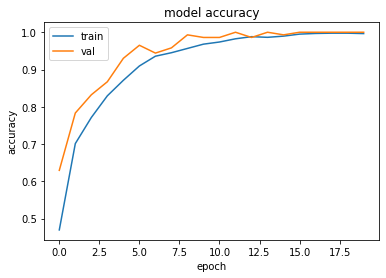

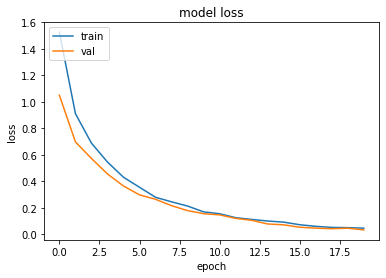

5/5 [==============================] - 1s 115ms/step - loss: 0.6577 - accuracy: 0.7972
Test loss: 0.6576778292655945
Test accuracy: 0.7972028255462646
/content/Fish_upload/Fish_upload/Validation/Bodianus
/content/Fish_upload/Fish_upload/Validation/Coris
/content/Fish_upload/Fish_upload/Validation/Epinephelus
/content/Fish_upload/Fish_upload/Validation/Halichoeres
/content/Fish_upload/Fish_upload/Validation/Lethrinus
/content/Fish_upload/Fish_upload/Validation/Lutjanus
/content/Fish_upload/Fish_upload/Validation/Pseudanthias
/content/Fish_upload/Fish_upload/Validation/Thalassoma


In [ ]:
# Run the models


# 1- VGG-16
model_VGG16=run_model_VGG16()
evaluate_model_testset(model_VGG16)
plot_random_images_form_each_class(model_VGG16,(224,224))

80142336/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


87/87 [==============================] - 18s 185ms/step - loss: 1.7286 - accuracy: 0.3624 - val_loss: 1.2650 - val_accuracy: 0.5524
Epoch 2/20
87/87 [==============================] - 16s 188ms/step - loss: 1.0491 - accuracy: 0.6343 - val_loss: 0.7441 - val_accuracy: 0.7762
Epoch 3/20
87/87 [==============================] - 17s 190ms/step - loss: 0.6449 - accuracy: 0.7838 - val_loss: 0.4300 - val_accuracy: 0.8601
Epoch 4/20
87/87 [==============================] - 17s 193ms/step - loss: 0.4510 - accuracy: 0.8470 - val_loss: 0.3023 - val_accuracy: 0.9021
Epoch 5/20
87/87 [==============================] - 17s 195ms/step - loss: 0.2764 - accuracy: 0.9159 - val_loss: 0.1522 - val_accuracy: 0.9860
Epoch 6/20
87/87 [==============================] - 17s 197ms/step - loss: 0.1935 - accuracy: 0.9411 - val_loss: 0.1097 - val_accuracy: 0.9790
Epoch 7/20
87/87 [==============================] - 17s 201ms/step - loss: 0.1258 - accuracy: 0.9641 - val_loss: 0.0976 - val_accuracy: 0.9930
Epoch 8/20

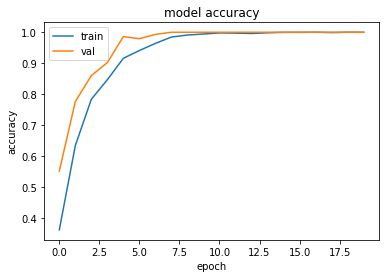

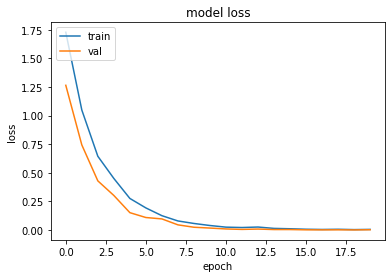

5/5 [==============================] - 1s 143ms/step - loss: 0.6862 - accuracy: 0.8182
Test loss: 0.686196506023407
Test accuracy: 0.8181818127632141


In [ ]:
# 2- VGG-19
model_VGG19=run_model_VGG19()
evaluate_model_testset(model_VGG19)
plot_random_images_form_each_class(model_VGG19,(224,224))

In [ ]:
# 3- AlexNet
AlexNet = run_model_AlexNet()

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Loss: 1.6870 Acc: 0.4095
Validation Loss: 1.3884 Acc: 0.5035

Epoch 1/24
----------
Train Loss: 1.3778 Acc: 0.5241
Validation Loss: 1.2126 Acc: 0.5664

Epoch 2/24
----------
Train Loss: 1.2169 Acc: 0.5808
Validation Loss: 1.0525 Acc: 0.6503

Epoch 3/24
----------
Train Loss: 1.1177 Acc: 0.6088
Validation Loss: 0.8392 Acc: 0.7552

Epoch 4/24
----------
Train Loss: 1.0362 Acc: 0.6325
Validation Loss: 0.6797 Acc: 0.7413

Epoch 5/24
----------
Train Loss: 0.9884 Acc: 0.6501
Validation Loss: 0.6037 Acc: 0.8042

Epoch 6/24
----------
Train Loss: 0.9119 Acc: 0.6767
Validation Loss: 0.6469 Acc: 0.7692

Epoch 7/24
----------
Train Loss: 0.6513 Acc: 0.7701
Validation Loss: 0.4396 Acc: 0.8531

Epoch 8/24
----------
Train Loss: 0.5354 Acc: 0.8085
Validation Loss: 0.3875 Acc: 0.9021

Epoch 9/24
----------
Train Loss: 0.5061 Acc: 0.8186
Validation Loss: 0.3089 Acc: 0.9091

Epoch 10/24
----------
Train Loss: 0.4773 Acc: 0.8226
Validation Loss: 0.3207 Acc: 0.8811

Epoch 11/24
----------
Train Lo

Found 4541 files belonging to 8 classes.
Using 4087 files for training.
Found 4541 files belonging to 8 classes.
Using 454 files for validation.
Epoch 1/20
32/32 [==============================] - 13s 289ms/step - loss: 1.9091 - accuracy: 0.3181 - val_loss: 1.5364 - val_accuracy: 0.4581
Epoch 2/20
32/32 [==============================] - 10s 261ms/step - loss: 1.2312 - accuracy: 0.5767 - val_loss: 0.9762 - val_accuracy: 0.6696
Epoch 3/20
32/32 [==============================] - 10s 261ms/step - loss: 0.7645 - accuracy: 0.7468 - val_loss: 0.6529 - val_accuracy: 0.7533
Epoch 4/20
32/32 [==============================] - 10s 266ms/step - loss: 0.5569 - accuracy: 0.8187 - val_loss: 0.5452 - val_accuracy: 0.8018
Epoch 5/20
32/32 [==============================] - 10s 262ms/step - loss: 0.3734 - accuracy: 0.8806 - val_loss: 0.4724 - val_accuracy: 0.8348
Epoch 6/20
32/32 [==============================] - 10s 262ms/step - loss: 0.2512 - accuracy: 0.9234 - val_loss: 0.3697 - val_accuracy: 0.88

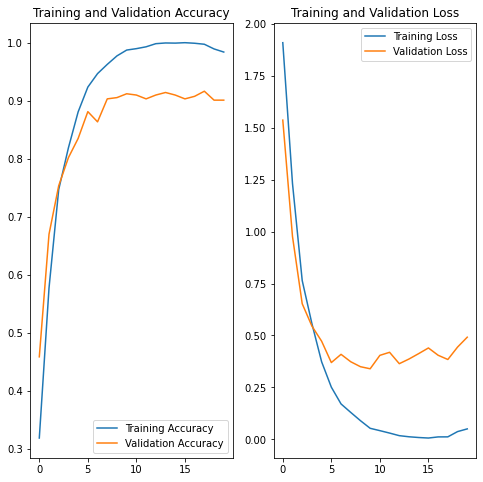

In [ ]:
# 4- Our Model
run_model()

Found 3036 files belonging to 9 classes.
Using 2733 files for training.
Found 3036 files belonging to 9 classes.
Using 303 files for validation.
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_input (InputLayer) [(None, 120, 120, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 120, 120, 3)       0         
_________________________________________________________________
block1_conv (Conv2D)         (None, 116, 116, 32)      2432      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 58, 58, 32)        0         
_________________________________________________________________
block2_conv (Conv2D)         (None, 56, 56, 32)        9248      
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 32

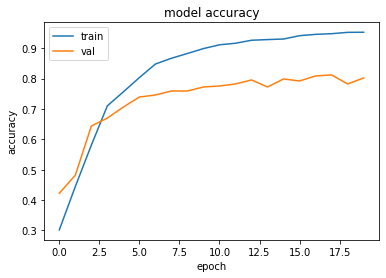

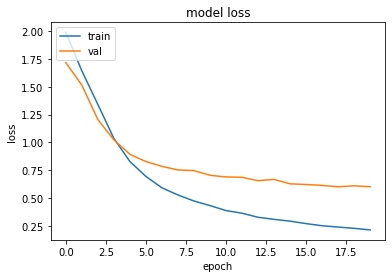

In [ ]:
# 5- Transfer Learning to our model for 9 classes
TL_OurModel=run_TF_OurModel()